# Low-level Control Mini-Project

<a target="_blank" href="https://colab.research.google.com/github/CLAIR-LAB-TECHNION/AIR/blob/main/tutorials-2025/Tut03-low_level_control_mini_project--SOLVED.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**Before you start, change to GPU runtime, so rendering cells will run faster.** To do that go to Runtime->Change runtime type->choose T4 GPU and save.
If at some point you get an error that you are out of your GPU quota, you can go back to cpu runtime, some cells will just run slower.

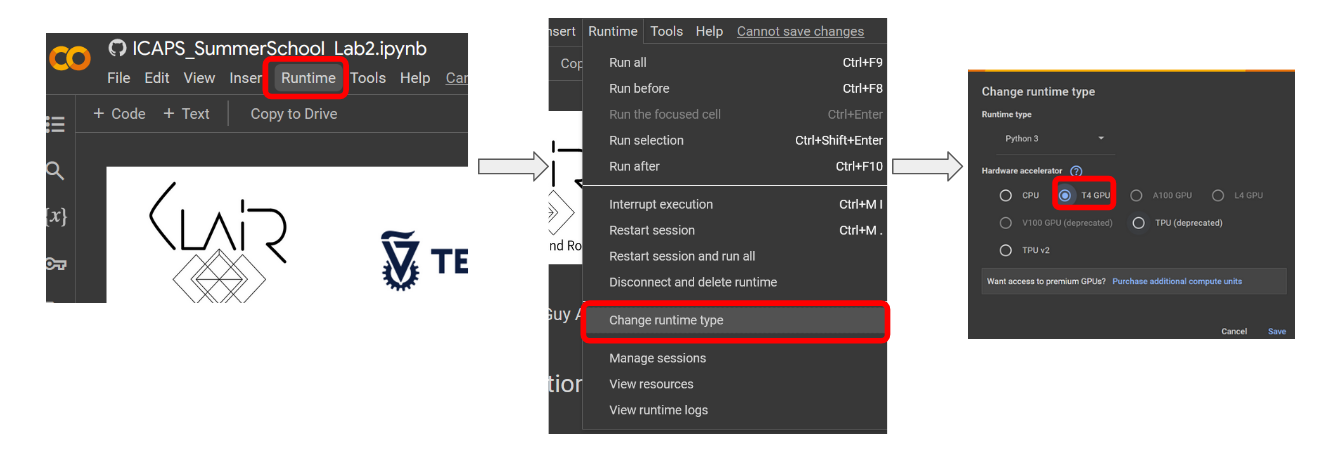

## Mini-Project Overview

In this tutorial you will build upon the knowledge you acquired from the previous tutorial to implement a control loop with a UR5e robot in MuJoCo. You will implement a proportional controller to control the robot's end-effector to reach a desired position in 3D space. For this, you will need to read and understand an MJCF file, extract information from the MuJoCo simulation, and implement a control loop that updates the robot's joint positions based on the proportional controller's output.

## Setup

In [ ]:
# install required packages
!pip install mujoco
!pip install mediapy
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)

# Enable GPU rendering in Colab
import os
import subprocess
from sys import stderr

try:
  is_gpu = not bool(subprocess.run('nvidia-smi').returncode)
except FileNotFoundError as e:
  is_gpu = False
if is_gpu:
  # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
  # This is usually installed as part of an Nvidia driver package, but the Colab
  # kernel doesn't install its driver via APT, and as a result the ICD is missing.
  # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
  NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
  if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
      f.write("""{
      "file_format_version" : "1.0.0",
      "ICD" : {
          "library_path" : "libEGL_nvidia.so.0"
      }
  }
  """)
else:
  print(
    'Cannot communicate with GPU.\n'
    'Make sure you are using a GPU Colab runtime.\n'
    'Go to the Runtime menu and select Choose runtime type.\n'
    'You can also skip this and use CPU with slower rendering.',
    file=stderr)
  
# Set the EGL backend for MuJoCo
import platform

is_apple_silicon = platform.system() == "Darwin" and platform.processor() == "arm"
if not is_apple_silicon:
  %env MUJOCO_GL=egl

Cannot communicate with GPU.
Make sure you are using a GPU Colab runtime.
Go to the Runtime menu and select Choose runtime type.
You can also skip this and use CPU with slower rendering.


## Environment

We will use the same environment as the previous tutorial: UR5e on a table with a single red box.

fatal: destination path 'mujoco_menagerie' already exists and is not an empty directory.
UR5e robot MJCF path: mujoco_menagerie/universal_robots_ur5e/ur5e.xml

rendering all available viewpoints

leftsideview


""

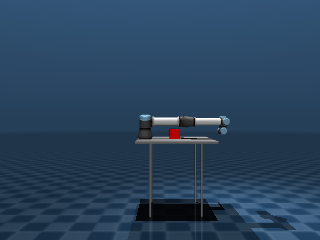

rightsideview


""

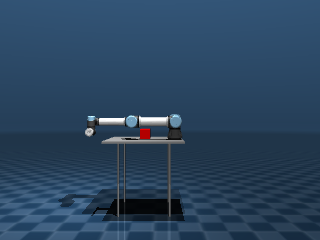

frontview


""

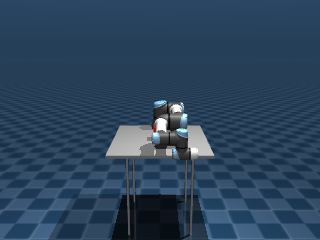

leftangleview


""

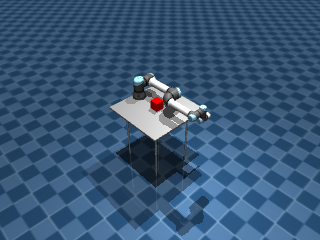

rightangleview


""

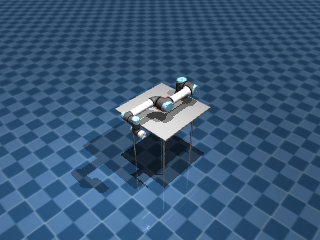

birdview


""

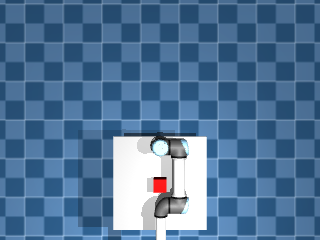

In [ ]:
!git clone https://github.com/google-deepmind/mujoco_menagerie
(robot_path,) = !find mujoco_menagerie -name "ur5e.xml"
print(f"UR5e robot MJCF path: {robot_path}\n")

xml = """
<mujoco model="tableworld">
    <statistic center="0.3 0 0.4" extent="0.8"/>

    <visual>
        <headlight diffuse="0.6 0.6 0.6" ambient="0.1 0.1 0.1" specular="0 0 0"/>
        <rgba haze="0.15 0.25 0.35 1"/>
        <global azimuth="45" elevation="-20"/>
    </visual>

    <asset>
        <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512" height="3072"/>
        <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="0.2 0.3 0.4" rgb2="0.1 0.2 0.3"
                 markrgb="0.8 0.8 0.8" width="300" height="300"/>
        <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5" reflectance="0.2"/>
    </asset>

    <worldbody>
        <light pos="0 0 1.5" dir="0 0 -1" directional="true"/>
        <geom name="floor" pos="0.0 0.0 0.0" size="0 0 0.05" type="plane" material="groundplane"/>

        <body name="table" pos="0.3 0.0 0">
            <geom name="table_top" type="box" size=".37 .37 .01" pos="0 0 .7"/>
            <geom name="table_leg_1" type="cylinder" size=".01 .7" pos=".24 -.24 -.0" euler="0 0 0"/>
            <geom name="table_leg_2" type="cylinder" size=".01 .7" pos=".24 .24 -.0" euler="0 0 0"/>
            <geom name="table_leg_3" type="cylinder" size=".01 .7" pos="-.24 -.24 -.0" euler="0 0 0"/>
            <geom name="table_leg_4" type="cylinder" size=".01 .7" pos="-.24 .24 -.0" euler="0 0 0"/>
        </body>

        <body name="red_box" pos="0.3 0 0.76" quat="0. 0. 1. 0.">
            <freejoint/>
            <geom type="box" size=".05 .05 .05" rgba="1 0 0 1"/>
        </body>

        <!--angle view-->
        <camera name="rightangleview" pos="2.182 1.724 2.590" xyaxes="-0.685 0.729 0.000 -0.456 -0.429 0.780"/>
        <camera name="leftangleview" pos="2.182 -1.724 2.590" xyaxes="0.685 0.729 0.000 -0.456 0.429 0.780"/>
        <!-- front view -->
        <camera mode="fixed" name="frontview" pos="2.5 0 1.45" quat="0.56 0.43 0.43 0.56"/>
        <!-- bird view -->
        <camera mode="fixed" name="birdview" pos="0.3 0 3.0" quat="0.7071 0 0 0.7071"/>
        <!-- side view -->
        <camera mode="fixed" name="leftsideview" pos="0.151 -2.941 0.9" xyaxes="1.000 0.000 0.000 0.000 0.000 1.000"/>
        <camera mode="fixed" name="rightsideview" pos="0.151 2.941 0.9" xyaxes="-1.000 0.000 0.000 0.000 0.000 1.000"/>


    </worldbody>

</mujoco>
"""

import mujoco
import mediapy as media

scene_spec = mujoco.MjSpec.from_string(xml)
robot_spec = mujoco.MjSpec.from_file(robot_path)

# create a mount (body + site) in the parent where the robot should attach
mount = scene_spec.worldbody.add_body(name="mount", pos=[0.0, 0.0, 0.72], xyaxes=[-1, 0, 0, 0, -1, 0])
mount_site = mount.add_site(name="mount_site", pos=[0, 0, 0])

# attach the entire robot spec to the parent's mount site (prefix renames attached elements)
scene_spec.attach(robot_spec, site=mount_site, prefix="")

# compile into a model and data
model = scene_spec.compile()
data = mujoco.MjData(model)

print('rendering all available viewpoints\n')

with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)

    print('leftsideview')
    renderer.update_scene(data, camera="leftsideview")
    media.show_image(renderer.render())

    print('rightsideview')
    renderer.update_scene(data, camera="rightsideview")
    media.show_image(renderer.render())

    print('frontview')
    renderer.update_scene(data, camera="frontview")
    media.show_image(renderer.render())

    print('leftangleview')
    renderer.update_scene(data, camera="leftangleview")
    media.show_image(renderer.render())

    print('rightangleview')
    renderer.update_scene(data, camera="rightangleview")
    media.show_image(renderer.render())

    print('birdview')
    renderer.update_scene(data, camera="birdview")
    media.show_image(renderer.render())

## Constant Control

In this task, your goal is to actuate the robot so it reaches the home configuration. To start, we will define a `Policy` class that will serve as a base for our control policies. Additionally, we provide a `run_and_render_policy` function that will execute a given policy in the MuJoCo simulation for a given duration and render the results.

In [3]:
from abc import ABC, abstractmethod


class Policy(ABC):
    """
    Abstract base class for control policies in MuJoCo.

    Args:
        model (mujoco.MjModel): The MuJoCo model object.
    """

    def __init__(self, model: mujoco.MjModel):
        self.model = model

    @abstractmethod
    def set_control(self, data: mujoco.MjData):
        """
        Set the control inputs for the actuators in the data object.
        Args:
            data (mujoco.MjData): The MuJoCo data object.
        """
        pass


def run_and_render_policy(model: mujoco.MjModel,
                          data: mujoco.MjData,
                          policy: Policy,
                          duration: float,
                          framerate: int,
                          camera: str = "frontview"):
    
    """
    Run a simulation with the given policy and render the result as a video.

    Args:
        model (mujoco.MjModel): The MuJoCo model object.
        data (mujoco.MjData): The MuJoCo data object.
        policy (Policy): The control policy to use.
        duration (float): The duration of the simulation in seconds.
        framerate (int): The framerate for rendering the video in Hz.
        camera (str): The name of the camera to use for rendering. defaults to "frontview".
    """
    mujoco.mj_resetData(model, data)  # Reset state and time.

    frames = []
    with mujoco.Renderer(model) as renderer:
        while data.time < duration:
            policy.set_control(data)

            mujoco.mj_step(model, data)

            if len(frames) < data.time * framerate:
                renderer.update_scene(data, camera=camera)
                pixels = renderer.render()
                frames.append(pixels)

    media.show_video(frames, fps=framerate)

The `Policy` class has one simple job, to set the control inputs for the actuators at each time step.

Remember, the robot's actuators receive the desired joint positions as control input. Therefore, to get to the home position, we only need to constantly set the control inputs to the home position values.

Implement a constant control value policy.

In [4]:
class ConstantControlPolicy(Policy):
    def __init__(self, model: mujoco.MjModel, control_value: list[float]):
        super().__init__(model)
        self.control_value = control_value

    def set_control(self, data: mujoco.MjData):
        data.ctrl[:] = self.control_value

The robot's home configuration is at the following joint positions (in radians):
```
0 -1.5708 1.5708 -1.5708 -1.5708 0
```

Run a simulation with a constant control value policy that sets the control inputs to the home position values.

In [5]:
home_config_policy = ConstantControlPolicy(model, control_value=[0, -1.5708, 1.5708, -1.5708, -1.5708, 0])
run_and_render_policy(model, data, home_config_policy, duration=2.0, framerate=60)

## Proportional Control

It's all good and well that we can set the robot to a specific joint configuration, but our tasks are often defined in 3D space. Specifically, we want to control the end-effector's position in Cartesian coordinates (x, y, z). The process of calculating the joint positions required to achieve a desired end-effector position is known as [inverse kinematics](https://en.wikipedia.org/wiki/Inverse_kinematics) (IK). However, soliving IK is not trivial and often requires numerical methods to find an approximate solution. Instead of implementing a full IK solver, we will use an alternative approach: proportional (P-only) control.


The idea of proportional control is simple: we calculate the error between the current end-effector position and the desired position, and then we set the control inputs to be proportional to this error. This way, the robot will move towards the desired position. Concretely, assume we have a desired end-effector position $r$ and the current end-effector position at time $t$ is $p(t)$. The error is then defined as
$$
e(t) = r - p(t)
$$
The control input $u(t)$ is then set to be proportional to this error:
$$
u(t) = K_p * e(t)
$$
where $K_p$ is a proportional gain that determines how aggressively the robot moves towards the target.

### Finding the End-Effector

First, we need to know the end-effector's position at each time step. The process of obtaining the end-effector's position from the robot's joint positions is known as [forward kinematics](https://en.wikipedia.org/wiki/Forward_kinematics) (FK). Concretely, forwad kinematics corresponds to a function 
$$
f:\mathbb{R}^n\rightarrow\mathbb{R}^3
$$
that transforms the robot's configurations to the end-effector's position. Unlike IK, FK is straightforward and can be computed directly from the robot's kinematic chain. However, implementing FK for a 6-DOF robot like the UR5e can be quite involved, as it requires knowledge of the robot's Denavit-Hartenberg parameters and matrix transformations. Fortunately, we are in simulation, so we can probe MuJoCo for the end-effector's position directly.

Consider the robot's MJCF description:

In [6]:
with open(robot_path) as f:
    print(f.read())

<mujoco model="ur5e">
  <compiler angle="radian" meshdir="assets" autolimits="true"/>

  <option integrator="implicitfast"/>

  <default>
    <default class="ur5e">
      <material specular="0.5" shininess="0.25"/>
      <joint axis="0 1 0" range="-6.28319 6.28319" armature="0.1"/>
      <general gaintype="fixed" biastype="affine" ctrlrange="-6.2831 6.2831" gainprm="2000" biasprm="0 -2000 -400"
        forcerange="-150 150"/>
      <default class="size3">
        <default class="size3_limited">
          <joint range="-3.1415 3.1415"/>
          <general ctrlrange="-3.1415 3.1415"/>
        </default>
      </default>
      <default class="size1">
        <general gainprm="500" biasprm="0 -500 -100" forcerange="-28 28"/>
      </default>
      <default class="visual">
        <geom type="mesh" contype="0" conaffinity="0" group="2"/>
      </default>
      <default class="collision">
        <geom type="capsule" group="3"/>
        <default class="eef_collision">
          <geom type="c

The end-effector has a site where attachments can be made (e.g., for a gripper or tool). This is where the end-effector's position is defined. Find this site, then write a function to get the end-effector's position from the simulation data.

In [7]:
import numpy as np

# returns a numpy array of shape (3,)
def get_ee_pos(data: mujoco.MjData) -> np.ndarray:
    """
    Get the end-effector's position from the simulation data.

    Args:
        data (mujoco.MjData): The MuJoCo data object.

    Returns:
        np.ndarray: The end-effector's position as a numpy array of shape (3,).
    """
    # find the site named "attachment_site"
    ee_attachment_site_data = data.site('attachment_site')

    # use `xpos` to get the COM of the attachment cite
    ee_3d_pos = ee_attachment_site_data.xpos
    
    return ee_3d_pos.copy()

# If the data was not reset since the last simulation, the robot should be at home position
home_config_ee_pos = get_ee_pos(data)
print("End-effector position at home configuration:", home_config_ee_pos)

End-effector position at home configuration: [0.49261866 0.13399517 1.19895402]


### The Jacobian Matrix

Excellent! Now, given a target position, we can calculate the error and set the control inputs accordingly. Implement a proportional control policy that moves the end-effector to a desired position in 3D space. However, proportional control is defined in Cartesian space, while the robot's actuators work in joint space. To convert the Cartesian control input to joint positions, we can use the Jacobian matrix of the robot's FK function $J(q)$, which relates the joint velocities to the end-effector velocities.

MuJoCo provides us with a function `mujoco.mj_jacSite` (found [here](https://mujoco.readthedocs.io/en/3.1.2/APIreference/APIfunctions.html#mj-jacsite)) that computes the Jacobian matrix for a given site. Here is the function signature:
```c
void mj_jacSite(const mjModel* m, const mjData* d, mjtNum* jacp, mjtNum* jacr, int site);
// m: pointer to the model
// d: pointer to the data
// jacp: pointer to a 3xn array where the position Jacobian will be stored
// jacr: pointer to a 3xn array where the rotation Jacobian will be stored
// site: index of the site for which the Jacobian is to be computed
// After execution, jacp will contain the positional Jacobian and jacr will contain the rotational Jacobian
```

In python, the model and data pointers are simiply the data objects, `jacp` and `jacr` are empty numpy arrays of shape `(3, num_dofs)` to be filled by this function, and `site` corresponds to the element's index.

Write a function to compute the positional Jacobian matrix for a named site.

Hint:
- the number of degrees of freedom (DOFs) can be obtained from the model using `model.nv`.
- you don't have to provide an array for the rotation Jacobian if you don't need it, you can pass `None` instead.


In [8]:
def compute_site_jacobian(model: mujoco.MjModel, data: mujoco.MjData, site_name: str) -> np.ndarray:
    """
    Compute the Jacobian of a site with respect to the robot's joint positions.

    Args:
        model (mujoco.MjModel): The MuJoCo model object.
        data (mujoco.MjData): The MuJoCo data object.
        site_name (str): The name of the site.

    Returns:
        np.ndarray: The positional Jacobian matrix of shape (3, n), where n is the number of joints.
    """
    # find the site id
    site_id = model.site(site_name).id

    # positional Jacobian placeholder
    jacp = np.empty((3, model.nv))

    # compute the Jacobian using mujoco.mj_jacSite
    mujoco.mj_jacSite(model, data, jacp, None, site_id)

    return jacp  # return only the position Jacobian

print("End-effector Jacobian shape: ", compute_site_jacobian(model, data, "attachment_site").shape)

End-effector Jacobian shape:  (3, 12)


We have now computed the Jacobian matrix for all the DOFs in the simulation. However, we only need the columns corresponding to the robot. Let's write a function to only get the Jacobian for our UR5e's end-effector containing only the columns corresponding to the robot's DOFs.

In general, a DOF in MuJoCo corresponds to a specific kind of velocity that a body can have out of the 6 possible spatial velocities (3 for translation and 3 for rotation). Each DOF has a unique index in the simulation, corresponding to its position in the state's velocity vector `data.qvel`, which also applies to the jacobian matrix we computed above. Each body's DOFs are contiguous in this vector, i.e., if a body has `k` DOFs, they will be located at indices `i, i+1, ..., i+k-1` for some starting index `i`. The start index for a body's DOFs can be obtained using the `dofadr` property of its model object. The number of DOFs for a body can be obtained using the `dofnum` property of its model object.



In [9]:
def compute_ur5e_ee_jacobian(model: mujoco.MjModel, data: mujoco.MjData) -> np.ndarray:
    """
    Compute the Jacobian of the UR5e's end-effector with respect to the robot's joint positions.

    Args:
        model (mujoco.MjModel): The MuJoCo model object.
        data (mujoco.MjData): The MuJoCo data object.

    Returns:
        np.ndarray: The positional Jacobian matrix of shape (3, 6), where 6 is the number of UR5e joints.
    """
    # UR5e joint names in the order they appear in the MJCF
    ur5e_body_names = [
        'shoulder_link',
        'upper_arm_link',
        'forearm_link',
        'wrist_1_link',
        'wrist_2_link',
        'wrist_3_link'
    ]

    # get the DOF indices for the UR5e bodies
    ur5e_dof_indices = []
    for body_name in ur5e_body_names:
        body = model.body(body_name)

        # get the DOF indices for this body
        # NOTE: it is enough to use `dofadr` without defining this range if all bodies are 1-DOF
        #       as is the case for the UR5e because all joints are 1-DOF. This code covers the general
        #       case where `dofadr` is only the starting index of the body's DOFs.
        body_dofs_start = body.dofadr[0]  # output is a list of length 1
        body_dofs_end = body_dofs_start + body.dofnum[0]  # contiguous range of DOFs
        body_dofs = list(range(body_dofs_start, body_dofs_end))
        ur5e_dof_indices.extend(body_dofs)

    # compute the full Jacobian for the attachment site
    full_jacobian = compute_site_jacobian(model, data, "attachment_site")

    # extract only the columns corresponding to the UR5e bodies
    ur5e_jacobian = full_jacobian[:, ur5e_dof_indices]

    return ur5e_jacobian

ur5e_ee_jacobian = compute_ur5e_ee_jacobian(model, data)

print("End-effector Jacobian shape: ", ur5e_ee_jacobian.shape)
print("End-effector linear velocity: ", ur5e_ee_jacobian @ data.qvel[6:])  # only last 6 DOFs are the UR5e's joints

End-effector Jacobian shape:  (3, 6)
End-effector linear velocity:  [0.00902889 0.01380554 0.03479395]


### Proportional Control Policy

Now, if we treat the control input $u(t)$ as a desired end-effector velocity, we can compute the corresponding joint velocities using the pseudo-inverse of the Jacobian matrix:
$$\dot{q}(t) = J(q(t))^+ * u(t)
$$
where $J(q(t))^+$ is the pseudo-inverse of the Jacobian matrix at the current joint configuration, computable using `numpy.linalg.pinv`.

Finally, we can integrate the joint velocities to get the new joint positions:
$$
q(t+1) = q(t) + \dot{q}(t) * dt
$$
Where $dt$ is the time step of the simulation, obtainable via `model.opt.timestep`.

Let's put it all together and implement a proportional control policy that moves the end-effector to a desired position in 3D space.

In [10]:
class ProportionalEEPositionControlPolicy(Policy):
    def __init__(self, model: mujoco.MjModel, target_ee_pos: np.ndarray, kp: float):
        super().__init__(model)
        self.target_ee_pos = target_ee_pos
        self.kp = kp

    def set_control(self, data: mujoco.MjData):
        # get current end-effector position
        current_ee_pos = get_ee_pos(data)

        # compute position error
        pos_error = self.target_ee_pos - current_ee_pos

        # compute desired end-effector velocity using proportional control
        desired_ee_vel = self.kp * pos_error

        # compute the Jacobian for the UR5e's end-effector
        jacobian = compute_ur5e_ee_jacobian(self.model, data)

        # compute joint velocities using the pseudo-inverse of the Jacobian
        joint_velocities = np.linalg.pinv(jacobian) @ desired_ee_vel

        # integrate joint velocities to get new joint positions
        dt = self.model.opt.timestep
        current_joint_positions = data.qpos[7:]  # only last 6 DOFs are the UR5e's joints
        new_joint_positions = current_joint_positions + joint_velocities * dt

        # set the control inputs to the new joint positions
        data.ctrl[:] = new_joint_positions

Let's try out our new policy. We previously saved the end-effector's position at its home configuration. Set the target position to `home_config_ee_pos` and run the simulation. Play around with the proportional gain $K_p$ to see how it affects the robot's movement. Pick a value that brings the end-effector as close as possible to the target position without overshooting.

In [11]:
home_config_ee_pos_policy = ProportionalEEPositionControlPolicy(model, home_config_ee_pos, kp=1000.0)
run_and_render_policy(model, data, home_config_ee_pos_policy, duration=2.0, framerate=60)

assert np.allclose(get_ee_pos(data), home_config_ee_pos, atol=1e-2), "End-effector did not reach the target position!"

Notice how even though we set the end-effector's target position to its home configuration, the robot might not reach the home configuration as in the constant control policy. Why is that? Our controller only considers the end-effector's position, not its orientation. Therefore, the robot might reach the target position with a different orientation than the home configuration. Nevertheless, we can now define tasks in Cartesian space rather than joint space.

## Final Task

You now have all you need to complete the final task: pushing the red box off the table. Concretely, you must:
1. Bring the robot to its home configuration.
2. Control the end-effector to move the box off the table.
3. Once the box is no longer on the table, go back to the home configuration.

Write a policy that accomplishes this task. You can use the functions you implemented above to help you. You can also define additional helper functions if needed.

In [12]:
class TargetCOMTrackingPolicy(ProportionalEEPositionControlPolicy):
    def __init__(self, model: mujoco.MjModel, target_body_name: str, kp: float):
        super().__init__(model, target_ee_pos=np.zeros(3), kp=kp)
        self.target_body_name = target_body_name
        self.kp = kp

    def set_control(self, data: mujoco.MjData):
        # update the target end-effector position to the current COM of the target body
        self.target_ee_pos = data.body(self.target_body_name).xpos

        # call the parent class's set_control method to perform the control
        super().set_control(data)

class BoxPushPolicy(Policy):
    def __init__(self, model: mujoco.MjModel):
        super().__init__(model)

        # a policy to take the robot to its home configuration
        self.home_config_policy = ConstantControlPolicy(model, [0, -1.5708, 1.5708, -1.5708, -1.5708, 0])

        # a policy to move the end-effector slightly to the side of the box's COM
        red_box_model_entity = model.body("red_box")  # find box entity in the model
        red_box_com = red_box_model_entity.pos  # get box COM position
        red_box_width = model.geom_size[red_box_model_entity.geomadr[0]][1]  # box width along the Y-axis (size is half-extents)
        offset = np.array([0, red_box_width + 0.05, 0])  # offset along the Y-axis
        box_side_target = red_box_com + offset  # target position to the side of the box
        self.move_to_box_side_policy = ProportionalEEPositionControlPolicy(model, box_side_target, 1000)

        # a policy to move the end-effector to the box's COM
        self.box_tracking_policy = TargetCOMTrackingPolicy(model, "red_box", 1000)

        # divide the task into stages
        # 0. go home
        # 1. go to the side of the box
        # 2. push the box off the table
        # 3. return home
        self.stage = 0  # 0: go to home, 1: push box, 2: return to home


    def set_control(self, data: mujoco.MjData):
        if self.stage == 0:
            self.stage0(data)
        elif self.stage == 1:
            self.stage1(data)
        elif self.stage == 2:
            self.stage2(data)
        elif self.stage == 3:
            self.stage3(data)
        else:
            raise ValueError(f"Invalid stage: {self.stage}")

    def stage0(self, data: mujoco.MjData):
        self.home_config_policy.set_control(data)
        if np.allclose(data.qpos[7:], self.home_config_policy.control_value, atol=1e-1):
            print("Reached home configuration. Moving to stage 1.")
            self.stage = 1

    def stage1(self, data: mujoco.MjData):
        self.move_to_box_side_policy.set_control(data)
        if np.allclose(get_ee_pos(data), self.move_to_box_side_policy.target_ee_pos, atol=1e-2):
            print("Reached side of the box. Moving to stage 2.")
            self.stage = 2

    def stage2(self, data: mujoco.MjData):
        self.box_tracking_policy.set_control(data)
        box_height = data.body('red_box').xpos[2]
        if box_height < data.geom('table_top').xpos[2]:  # if the box is below the table height
            print("Box pushed off the table. Moving to stage 3.")
            self.stage = 3

    def stage3(self, data: mujoco.MjData):
        # return to home configuration
        # resume until the end of the simulation
        self.home_config_policy.set_control(data)

Let's run the simulation and see how well your policy performs.

In [13]:
box_push_policy = BoxPushPolicy(model)
run_and_render_policy(model, data, box_push_policy, duration=3.0, framerate=60)

assert data.body('red_box').xpos[2] < data.geom('table_top').xpos[2], "Box was not pushed off the table!"
assert np.allclose(get_ee_pos(data), home_config_ee_pos, atol=1e-1), "End-effector did not return to home position!"

Reached home configuration. Moving to stage 1.
Reached side of the box. Moving to stage 2.
Box pushed off the table. Moving to stage 3.


Excellent! The box should now be off the table, and the robot should be back at its home configuration. You can adjust the duration of the simulation in the `run_and_render_policy` function call to see how the robot performs over a longer period.

## Conclusion

In this tutorial, you implemented a proportional controller from scratch to control a UR5e robot in MuJoCo. You learned how to extract the end-effector's position and compute the Jacobian matrix, which are essential for implementing the control loop. All this work lays the foundation for more advanced control techniques, such as [PID control](https://en.wikipedia.org/wiki/Proportional–integral–derivative_controller) or [model predictive control](https://en.wikipedia.org/wiki/Model_predictive_control). These techniques don't take into account the geometric constraints of the robot, which can lead to avoidable collisions or singularities.

Let's add an obstacle to the scene and see how what happens when we try to bring the end effector to it's home position:

In [14]:
scene_spec.worldbody.add_geom(name="obstacle", type=mujoco.mjtGeom.mjGEOM_BOX,
              size=[.05, .3, 0.05], rgba=[0, 0, 1, 1], pos=[0.3, 0, 1.1])
model = scene_spec.compile()

home_config_ee_pos_policy = ProportionalEEPositionControlPolicy(model, home_config_ee_pos, kp=1000.0)
run_and_render_policy(model, data, home_config_ee_pos_policy, duration=2.0, framerate=60)

As we can see, the robot collides with the obstacle and gets stuck, even though home configuration is reachable. In the next tutorial, we will learn how to incorporate the robot's geometry using motion planning techniques.